# 0 — Imports, seeds, dispositivo, filtro de warnings

In [2]:
# Importação de bibliotecas padrão
import warnings, random, time, copy, os
from typing import Dict, Tuple

# Bibliotecas científicas, PyTorch e utilitários
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as T
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import pandas as pd

# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Semente para reprodutibilidade
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Garante que as operações da GPU sejam determinísticas 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Define o dispositivo: Apple Silicon (MPS), GPU CUDA ou CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print("Dispositivo:", DEVICE)


Dispositivo: mps


# 1 — Utilitários

Esta seção define funções auxiliares e a arquitetura da rede convolucional simples usada nos testes.
Também são implementadas as variações de treinamento com suporte a CutMix e AugMix (JSD loss).

In [3]:
# Função para criar um subconjunto do dataset com uma fração específica (ex: 5%)
def build_subset(ds, frac=0.05):
    idx = np.random.RandomState(SEED).permutation(len(ds))[: int(len(ds)*frac)]
    return Subset(ds, idx)

# Função que retorna um DataLoader com shuffle opcional
def make_loader(ds, batch=64, train=True):
    return DataLoader(ds, batch_size=batch, shuffle=train,
                      num_workers=0, pin_memory=False)

# Arquitetura CNN simples usada em todos os experimentos
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(64*8*8,256), nn.ReLU(),
                                nn.Linear(256,10))
    def forward(self,x): return self.fc(self.conv(x))

# ---- CutMix ---------------------------------------------------------------
# Gera uma região aleatória para troca de partes entre imagens (CutMix)
def rand_bbox(size, lam):
    W,H=size[2],size[3] # largura e altura da imagem
    cut_rat = np.sqrt(1.-lam) # proporção do corte
    cw,ch=int(W*cut_rat), int(H*cut_rat) # largura e altura do corte
    cx,cy=np.random.randint(W), np.random.randint(H) # centro do corte
    bbx1,bby1=np.clip(cx-cw//2,0,W), np.clip(cy-ch//2,0,H)
    bbx2,bby2=np.clip(cx+cw//2,0,W), np.clip(cy+ch//2,0,H)
    return bbx1,bby1,bbx2,bby2

# ---- AugMix + JSD ---------------------------------------------------------
# Calcula a divergência de Jensen-Shannon para regularização de AugMix
def jsd_loss(p0,p1,p2):
    kl = lambda p,q: (p*(p.log()-q.log())).sum(1).mean()
    pm = (p0+p1+p2)/3. # distribuição média
    return (kl(p0,pm)+kl(p1,pm)+kl(p2,pm))/3.

# Função que treina o modelo por uma época, com suporte a:
# - treinamento padrão
# - CutMix
# - AugMix com JSD
def train_epoch(model, loader, opt, criterion,
                cutmix=False, jsd=False, lambda_jsd=12., beta=1.):
    model.train(); total=0
    for batch in loader:
        opt.zero_grad()
        # --- AugMix + JSD
        if jsd:
            x1,x2,x_clean,y=[t.to(DEVICE) for t in batch]
            p_clean=torch.softmax(model(x_clean),1)
            p1=torch.softmax(model(x1),1)
            p2=torch.softmax(model(x2),1)
            ce=criterion(model(x_clean),y)
            loss=ce + lambda_jsd*jsd_loss(p_clean,p1,p2)
        # --- CutMix
        elif cutmix:
            x,y=batch[0].to(DEVICE), batch[1].to(DEVICE)
            lam=np.random.beta(beta,beta)
            ridx=torch.randperm(x.size(0)).to(DEVICE)
            y_a,y_b=y,y[ridx]
            bbx1,bby1,bbx2,bby2=rand_bbox(x.size(),lam)
            x[:,:,bbx1:bbx2,bby1:bby2]=x[ridx,:,bbx1:bbx2,bby1:bby2]
            lam=1-((bbx2-bbx1)*(bby2-bby1)/(x.size(-1)*x.size(-2)))
            out=model(x)
            loss=criterion(out,y_a)*lam+criterion(out,y_b)*(1-lam)
        # --- Demais
        else:
            x,y=batch[0].to(DEVICE), batch[1].to(DEVICE)
            loss=criterion(model(x),y)
        loss.backward(); opt.step(); total+=loss.item()
    return total/len(loader)

# Avalia o modelo no conjunto de teste
@torch.no_grad()
def test_acc(model, loader):
    model.eval(); cor=tot=0
    for x,y in loader:
        x,y=x.to(DEVICE),y.to(DEVICE)
        cor+=(model(x).argmax(1)==y).sum().item(); tot+=y.size(0)
    return 100*cor/tot

# Executa o treinamento completo, salvando histórico de loss, acurácia e tempo por época
def run(model, loaders:Tuple[DataLoader,DataLoader], epochs,
        cutmix=False, jsd=False):
    tr,te=loaders
    opt=optim.Adam(model.parameters(),lr=1e-3)
    crit=nn.CrossEntropyLoss()
    hist={"losses":[],"accuracies":[],"epoch_times":[]}
    for ep in range(epochs):
        t0=time.time()
        loss=train_epoch(model,tr,opt,crit,cutmix,jsd)
        acc=test_acc(model,te)
        hist["losses"].append(loss); hist["accuracies"].append(acc)
        hist["epoch_times"].append(time.time()-t0)
        print(f"Ep {ep+1:02d}: loss {loss:.3f}  acc {acc:.2f}%")
    return hist


# 2 — Transforms

Nesta seção são definidas as transformações utilizadas nos experimentos. Algumas são simples e baseadas no `torchvision`, como RandAugment e TrivialAugmentWide, enquanto outras são mais sofisticadas, como o AugMix (personalizado) e Albumentations (com suporte a operações mais diversas). Todas as transformações retornam tensores normalizados prontos para treino.

In [4]:
# Normalização usada em todos os casos: transforma os valores RGB para o intervalo [-1, 1]
norm = T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

# ------------------ Transformações Padrão ------------------

# RandAugment com N=2 operações e magnitude=9
rand_tf_raw    = T.Compose([T.RandAugment(2,9)])

# TrivialAugmentWide aplica uma transformação aleatória entre o disponível
trivial_tf_raw = T.Compose([T.TrivialAugmentWide()])

# ------------------ AugMix (customizado) ------------------
# Lista de augmentações utilizadas no AugMix manual
augmentations=[
    T.ColorJitter(0.4,0.4,0.4,0.1), # brilho, contraste, saturação, matiz
    T.RandomHorizontalFlip(),
    T.RandomRotation(15), 
    T.GaussianBlur(3)
]

# Implementação da mistura de imagens para o AugMix
def augmix(img,w=3,d=-1,a=1.):
    ws=np.random.dirichlet([a]*w).astype(np.float32) # pesos de mistura
    m=np.random.beta(a,a) # peso global da mistura
    mix=torch.zeros_like(F.to_tensor(img)) # tensor acumulador

    for i in range(w):
        img_aug=img.copy()
        depth=d if d>0 else np.random.randint(1,4) # profundidade de cada cadeia
        for _ in range(depth):
            img_aug=random.choice(augmentations)(img_aug)
        mix+=ws[i]*F.to_tensor(img_aug)
    # Combina a imagem original com a mistura e normaliza
    return norm((1-m)*F.to_tensor(img)+m*mix)

# Wrapper do AugMix para aplicar via __call__
class AugMixWrapper:
    def __call__(self,img): return augmix(img) # retorna tensor já normalizado

# ------------------ Albumentations ------------------

# Pipeline com transformações avançadas da biblioteca Albumentations
alb_tf = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(0.0625,0.1,15,p=0.5),
    A.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ToTensorV2()
], seed = SEED)

# Wrapper para aplicação do pipeline Albumentations em imagens PIL
class AlbWrapper:
    def __call__(self,img):
        return alb_tf(image=np.array(img))["image"]   # tensor normalizado


/Users/diogo/anaconda3/lib/python3.11/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# 3 — Dataset base & subset

Nesta seção, o CIFAR-10 é carregado em formato cru (sem transformações) para permitir diferentes variações de aumento de dados sobre o mesmo conjunto de imagens. São também definidos os subsets estratificados com frações específicas (1%, 2.5%, 5%, 10%), com seeds fixas para reprodutibilidade. Por fim, funções de apoio e classes são criadas para aplicar transformações específicas como RandAugment, TrivialAugment, AugMix e Albumentations.

In [5]:
# Caminho para salvar/baixar o CIFAR-10
root = "./data"

# Carrega o conjunto de treino SEM nenhuma transformação (para reuso posterior)
train_raw = torchvision.datasets.CIFAR10(
    root=root,
    train=True,
    download=True,
    transform=None
)

# Carrega o conjunto de teste com transformação fixa: ToTensor + Normalize
test_set = torchvision.datasets.CIFAR10(
    root=root,
    train=False,
    download=True,
    transform=T.Compose([T.ToTensor(), norm])
)

# -------------------- Criação de índices estratificados ----------------------

# Função que retorna índices estratificados por classe, mantendo distribuição proporcional
def make_idx_subset(ds, frac, seed=SEED):
    rng = np.random.RandomState(seed)
    targets = np.array(ds.targets)
    idx_cls = [np.where(targets == c)[0] for c in range(10)]  # separa por classe
    sub = np.hstack([
        rng.choice(lst, int(len(lst) * frac), replace=False)
        for lst in idx_cls
    ])
    rng.shuffle(sub)
    return sub

# Subsets estratificados com diferentes proporções do treino
IDX_01 = make_idx_subset(train_raw, 0.01)     # 1 %
IDX_02 = make_idx_subset(train_raw, 0.025)    # 2.5 %
IDX_05 = make_idx_subset(train_raw, 0.05)     # 5 %
IDX_10 = make_idx_subset(train_raw, 0.10)     # 10 %

# Escolha ativa do subset (pode trocar facilmente para testar outra fração)
idx_subset = IDX_10

# Subset efetivo do treino (base crua, sem transform ainda)
subset_train = Subset(train_raw, idx_subset)

# --------------------- Função para aplicar transformações sob o mesmo subset ---------------------

# Permite aplicar uma transformação nova sobre o mesmo conjunto de imagens (por índice)
def subset_view(transform):
    base = torchvision.datasets.CIFAR10(
        root=root,
        train=True,
        transform=transform,
        download=False
    )
    return Subset(base, idx_subset)

# --------------------- Wrappers para RandAugment e TrivialAugment ---------------------

# Retorna o mesmo subset com RandAugment + ToTensor + Normalize
def make_rand_ds():
    tf = T.Compose([rand_tf_raw, T.ToTensor(), norm])
    return subset_view(tf)

# Retorna o mesmo subset com TrivialAugment + ToTensor + Normalize
def make_trivial_ds():
    tf = T.Compose([trivial_tf_raw, T.ToTensor(), norm])
    return subset_view(tf)

# ---------- Wrappers de AugMix e Albumentations -----------------------------

# Dataset para AugMix com JSD. Retorna três versões da imagem:
# (versão_aug1, versão_aug2, versão_original, rótulo)
class AugMixDataset(torch.utils.data.Dataset):
    def __init__(self, base):
        self.base = base
    def _mix(self, img): return augmix(img)
    def __getitem__(self, i):
        img, y = self.base[i]
        return self._mix(img), self._mix(img), norm(T.ToTensor()(img)), y
    def __len__(self): return len(self.base)

# Dataset com Albumentations aplicada em tempo real.
# Retorna: (imagem_transformada, rótulo)
class AlbDataset(torch.utils.data.Dataset):
    def __init__(self, base): self.base = base
    def __getitem__(self, i):
        img, y = self.base[i]
        return AlbWrapper()(img), y
    def __len__(self): return len(self.base)

# 4 — Experimentos PUROS

Nesta etapa, são realizados os treinamentos com técnicas de data augmentation **isoladas**, ou seja, uma de cada vez. Isso permite avaliar o impacto individual de cada técnica no desempenho do modelo quando treinado com um subconjunto pequeno do CIFAR-10.

As técnicas testadas são:
- Sem aumento de dados
- RandAugment
- TrivialAugmentWide
- AugMix (com JSD loss)
- Albumentations
- CutMix

O histórico de desempenho (perdas, acurácias e tempo por época) é salvo em um dicionário `histories` para análise posterior.

In [6]:
# Dicionário para armazenar o histórico de cada experimento
histories = {}

# Define o conjunto de especificações dos experimentos "puros"
# Formato: nome → (dataset, usar CutMix?, usar JSD/AugMix?)
pure_specs = {
    "Sem Aug":  (subset_view(T.Compose([T.ToTensor(), norm])),  False, False),
    "RandAug":  (make_rand_ds(),                                False, False),
    "Trivial":  (make_trivial_ds(),                             False, False),
    "AugMix":   (AugMixDataset(subset_train),                   False, True ),
    "Albument": (AlbDataset(subset_train),                      False, False),
    "CutMix":   (subset_view(T.Compose([T.ToTensor(), norm])),  True,  False),
}

EPOCHS = 25  # Número de épocas de treino para todos os experimentos

# Loop pelos experimentos
for name, (ds, cutmix, jsd) in pure_specs.items():
    print(f"\n### {name} ###")

    # Cria os data loaders de treino e teste
    tr_loader = make_loader(ds, train=True)
    te_loader = make_loader(test_set, train=False)

    # Executa o treino com a técnica especificada
    histories[name] = run(
        SimpleCNN().to(DEVICE),           # modelo
        (tr_loader, te_loader),           # data loaders
        epochs=EPOCHS,                    # épocas
        cutmix=cutmix, jsd=jsd            # flags específicas para CutMix e AugMix
    )


### Sem Aug ###
Ep 01: loss 1.876  acc 41.40%
Ep 02: loss 1.510  acc 45.22%
Ep 03: loss 1.300  acc 51.12%
Ep 04: loss 1.123  acc 53.01%
Ep 05: loss 1.001  acc 54.10%
Ep 06: loss 0.854  acc 53.45%
Ep 07: loss 0.732  acc 56.34%
Ep 08: loss 0.593  acc 55.78%
Ep 09: loss 0.467  acc 56.39%
Ep 10: loss 0.372  acc 56.02%
Ep 11: loss 0.256  acc 55.02%
Ep 12: loss 0.197  acc 55.84%
Ep 13: loss 0.129  acc 55.96%
Ep 14: loss 0.075  acc 56.17%
Ep 15: loss 0.038  acc 56.16%
Ep 16: loss 0.023  acc 56.58%
Ep 17: loss 0.015  acc 56.97%
Ep 18: loss 0.007  acc 57.08%
Ep 19: loss 0.005  acc 57.43%
Ep 20: loss 0.004  acc 57.15%
Ep 21: loss 0.003  acc 57.12%
Ep 22: loss 0.003  acc 57.10%
Ep 23: loss 0.002  acc 57.08%
Ep 24: loss 0.002  acc 57.08%
Ep 25: loss 0.002  acc 57.14%

### RandAug ###
Ep 01: loss 2.087  acc 37.14%
Ep 02: loss 1.802  acc 41.39%
Ep 03: loss 1.671  acc 47.78%
Ep 04: loss 1.556  acc 49.11%
Ep 05: loss 1.483  acc 49.41%
Ep 06: loss 1.424  acc 54.09%
Ep 07: loss 1.369  acc 55.62%
Ep 08:

# 5 — Combinações Sequênciais A→B

Nesta etapa, avaliamos o impacto de aplicar duas técnicas de data augmentation em sequência, seguindo a ordem A → B. São testadas combinações viáveis entre RandAugment, TrivialAugmentWide, Albumentations, AugMix e CutMix. Algumas regras de viabilidade são aplicadas para evitar combinações inválidas, como aplicar duas técnicas que exigem tensores ou usar CutMix como primeira técnica.

O histórico de desempenho das combinações é salvo no mesmo dicionário `histories` para futura comparação com os experimentos puros.

In [7]:
# ---------- Mapeamento de transformações -------------------------------------

# Transformações PIL (ainda não viraram tensor)
RAW_PIL = {
    "Rand": rand_tf_raw,
    "Trivial": trivial_tf_raw
}

# Wrappers que retornam tensor já normalizado
WRAP_TENS = {
    "Albument": AlbWrapper(),
    "AugMix": AugMixWrapper()
}

# Ordem usada para gerar combinações (sem repetição e sem inversão duplicada)
ORDER = ["Rand", "Trivial", "Albument", "AugMix", "CutMix"]

# ---------- Regras para filtrar combinações inválidas ------------------------

def viable(a, b):
    if a == b:
        return False
    if b == "CutMix" and a != "CutMix":
        return True   # CutMix só pode vir em segundo
    if a == "CutMix":
        return False  # CutMix nunca pode ser o primeiro
    if b in RAW_PIL:
        return False  # Segunda técnica não pode precisar de PIL
    if a in WRAP_TENS and b in WRAP_TENS:
        return False  # tensor → tensor direto não é possível
    return True

def seq_name(a, b):
    return f"{a}->{b}"

# ---------- Combina as duas transformações em um único tf --------------------

def make_tf_seq(a, b):
    """
    Retorna um torchvision.transforms.Compose para A → B.
    Se a saída for ainda PIL, converte para tensor e normaliza.
    """
    chain = []

    # Primeira transformação
    if a in RAW_PIL:
        chain.append(RAW_PIL[a])
        still_pil = True
    else:
        chain.append(WRAP_TENS[a])
        still_pil = False

    # Segunda transformação
    if b in WRAP_TENS:
        chain.append(WRAP_TENS[b])
        still_pil = False

    # Se ainda for PIL, converte para tensor e normaliza
    if still_pil:
        chain.extend([T.ToTensor(), norm])

    return T.Compose(chain)

# ---------- Dataset wrapper para aplicar a sequência dinamicamente ----------

def wrap_dataset(base_ds, tf):
    class _Wrap(torch.utils.data.Dataset):
        def __init__(self, base):
            self.base = base
        def __getitem__(self, idx):
            img, y = self.base[idx]
            return tf(img), y
        def __len__(self):
            return len(self.base)
    return _Wrap(base_ds)

# ---------- Criação dos datasets com combinações sequenciais ----------------

seq_loaders = {}
for i, a in enumerate(ORDER):
    for b in ORDER[i + 1:]:
        if not viable(a, b):
            continue
        name = seq_name(a, b)
        tf_seq = make_tf_seq(a, b)
        ds_seq = wrap_dataset(subset_train, tf_seq)
        seq_loaders[name] = {
            "loaders": (make_loader(ds_seq, train=True),
                        make_loader(test_set, train=False)),
            "cutmix": (b == "CutMix"),  # ativa CutMix apenas se B for CutMix
            "jsd": False                # nenhuma combinação aqui usa JSD
        }

# ---------- Treinamento das sequências --------------------------------------
for name, info in seq_loaders.items():
    print(f"\n### {name} ###")
    histories[name] = run(
        SimpleCNN().to(DEVICE),
        info["loaders"],
        epochs=EPOCHS,
        cutmix=info["cutmix"],
        jsd=info["jsd"]
    )


### Rand->Albument ###
Ep 01: loss 2.099  acc 35.53%
Ep 02: loss 1.830  acc 44.34%
Ep 03: loss 1.707  acc 45.60%
Ep 04: loss 1.646  acc 50.36%
Ep 05: loss 1.550  acc 50.96%
Ep 06: loss 1.527  acc 52.41%
Ep 07: loss 1.482  acc 54.27%
Ep 08: loss 1.410  acc 55.81%
Ep 09: loss 1.369  acc 56.64%
Ep 10: loss 1.332  acc 58.65%
Ep 11: loss 1.291  acc 57.91%
Ep 12: loss 1.280  acc 60.33%
Ep 13: loss 1.246  acc 60.41%
Ep 14: loss 1.264  acc 60.22%
Ep 15: loss 1.223  acc 62.23%
Ep 16: loss 1.176  acc 61.97%
Ep 17: loss 1.183  acc 62.77%
Ep 18: loss 1.121  acc 63.29%
Ep 19: loss 1.100  acc 64.23%
Ep 20: loss 1.121  acc 61.75%
Ep 21: loss 1.069  acc 64.02%
Ep 22: loss 1.047  acc 63.05%
Ep 23: loss 1.054  acc 63.19%
Ep 24: loss 1.024  acc 63.38%
Ep 25: loss 1.016  acc 64.72%

### Rand->AugMix ###
Ep 01: loss 2.100  acc 38.71%
Ep 02: loss 1.800  acc 43.20%
Ep 03: loss 1.682  acc 46.85%
Ep 04: loss 1.614  acc 49.08%
Ep 05: loss 1.544  acc 51.15%
Ep 06: loss 1.498  acc 52.99%
Ep 07: loss 1.436  acc 5

# 5 — Combinações inversas B→A (novas sequências)

Nesta etapa, são executadas as mesmas combinações sequenciais de técnicas de aumento de dados vistas anteriormente, mas invertendo a ordem: agora testamos `B → A` ao invés de `A → B`. Essa inversão permite investigar se a ordem das técnicas influencia o desempenho do modelo. As mesmas regras de viabilidade são aplicadas, ajustando para que o `CutMix` continue sendo aplicado apenas como segunda técnica.

Os resultados são armazenados no mesmo dicionário `histories` para futura comparação com as sequências diretas.

In [8]:
# Dicionário onde serão armazenados os experimentos com combinações inversas
inv_loaders = {}

# Define a viabilidade das combinações inversas (B → A)
def viable_inv(a, b):
    # Evita duplicatas ou combinações inválidas
    if a == b:
        return False
    if a == "CutMix":
        return False    # CutMix nunca como primeiro
    if b == "CutMix":
        return True     # CutMix permitido como segundo
    if a in RAW_PIL and b in RAW_PIL:
        return False    # Segundo precisa estar em tensor
    if a in WRAP_TENS and b in WRAP_TENS:
        return False    # tensor → tensor ainda é inválido
    return True

# Geração das sequências B → A com as regras atualizadas
for i, a in enumerate(ORDER):
    for b in ORDER[i + 1:]:
        if not viable_inv(b, a):  # atenção: aqui é B → A
            continue
        name = f"{b}->{a}"  # nome no formato inverso
        tf_seq = make_tf_seq(b, a)  # ordem invertida
        ds_seq = wrap_dataset(subset_train, tf_seq)
        inv_loaders[name] = {
            "loaders": (make_loader(ds_seq, train=True),
                        make_loader(test_set, train=False)),
            "cutmix": (a == "CutMix"),  # CutMix como segunda técnica
            "jsd": False
        }

# Treinamento das combinações inversas
for name, info in inv_loaders.items():
    print(f"\n### {name} ###")
    histories[name] = run(
        SimpleCNN().to(DEVICE),
        info["loaders"],
        epochs=EPOCHS,
        cutmix=info["cutmix"],
        jsd=info["jsd"]
    )


### Albument->Rand ###
Ep 01: loss 1.971  acc 36.37%
Ep 02: loss 1.653  acc 39.65%
Ep 03: loss 1.525  acc 48.58%
Ep 04: loss 1.409  acc 51.50%
Ep 05: loss 1.343  acc 53.80%
Ep 06: loss 1.268  acc 54.21%
Ep 07: loss 1.197  acc 56.04%
Ep 08: loss 1.139  acc 57.26%
Ep 09: loss 1.068  acc 57.45%
Ep 10: loss 1.036  acc 59.65%
Ep 11: loss 0.973  acc 59.49%
Ep 12: loss 0.944  acc 60.84%
Ep 13: loss 0.889  acc 61.39%
Ep 14: loss 0.838  acc 60.82%
Ep 15: loss 0.807  acc 60.71%
Ep 16: loss 0.768  acc 61.81%
Ep 17: loss 0.702  acc 61.57%
Ep 18: loss 0.687  acc 62.75%
Ep 19: loss 0.653  acc 62.39%
Ep 20: loss 0.623  acc 61.98%
Ep 21: loss 0.582  acc 62.85%
Ep 22: loss 0.535  acc 63.07%
Ep 23: loss 0.528  acc 61.15%
Ep 24: loss 0.511  acc 62.48%
Ep 25: loss 0.492  acc 62.68%

### AugMix->Rand ###
Ep 01: loss 1.881  acc 40.35%
Ep 02: loss 1.567  acc 45.51%
Ep 03: loss 1.410  acc 48.52%
Ep 04: loss 1.318  acc 49.67%
Ep 05: loss 1.202  acc 52.53%
Ep 06: loss 1.089  acc 53.49%
Ep 07: loss 1.006  acc 5

# 5 - Combinações paralelas 50% A + 50% B

Nesta etapa, o subset de treinamento é dividido ao meio de forma estratificada e reprodutível, e cada metade recebe uma técnica diferente de data augmentation. O objetivo é testar o impacto de uma combinação paralela (em vez de sequencial) de duas técnicas distintas.

Foram consideradas apenas as técnicas que atuam diretamente sobre a imagem (RandAugment, TrivialAugmentWide, Albumentations, AugMix), **excluindo o CutMix**, que envolve mistura entre amostras e não é compatível com a lógica de aplicação independente por metade.

As 6 combinações possíveis entre essas 4 técnicas são testadas, com resultados armazenados no dicionário `histories`.

In [9]:
from itertools import combinations

# Técnicas que podem ser combinadas paralelamente (sem CutMix)
PAR_TECHS = ["Rand", "Trivial", "Albument", "AugMix"]

# Mapeia cada nome de técnica para a transformação correspondente (tensor + normalizado)
tf_single = {
    "Rand":      T.Compose([rand_tf_raw, T.ToTensor(), norm]),
    "Trivial":   T.Compose([trivial_tf_raw, T.ToTensor(), norm]),
    "Albument":  AlbWrapper(),      # já retorna tensor normalizado
    "AugMix":    AugMixWrapper(),   # idem
}

# Função que baralha e divide os índices do subset de forma reprodutível
def split_indices(base_idx, parts=2):
    rng = np.random.RandomState(SEED)
    perm = rng.permutation(base_idx)
    return np.array_split(perm, parts)

# Dicionário que guardará os data loaders das misturas paralelas
parallel2_loaders = {}

# Pega os índices originais do subset selecionado
base_idx = np.array(subset_train.indices)

# Para cada par de técnicas (6 combinações no total)
for a, b in combinations(PAR_TECHS, 2):
    name = f"{a}+{b} (metades)"
    idxA, idxB = split_indices(base_idx, 2)

    # Aplica a técnica A na primeira metade
    dsA = wrap_dataset(Subset(train_raw, idxA), tf_single[a])
    # Aplica a técnica B na segunda metade
    dsB = wrap_dataset(Subset(train_raw, idxB), tf_single[b])

    # Concatena os dois datasets aumentados
    concat_ds = torch.utils.data.ConcatDataset([dsA, dsB])
    
    # Cria os DataLoaders
    tr_loader = make_loader(concat_ds, train=True)
    te_loader = make_loader(test_set, train=False)

    # Armazena para posterior treino
    parallel2_loaders[name] = (tr_loader, te_loader)

# ------ Treinamento das combinações paralelas ----------------------------------
for name, loaders in parallel2_loaders.items():
    print(f"\n### {name} ###")
    histories[name] = run(
        SimpleCNN().to(DEVICE),
        loaders,
        epochs=EPOCHS,
        cutmix=False,
        jsd=False  # nenhuma técnica aqui usa JSD
    )


### Rand+Trivial (metades) ###
Ep 01: loss 2.090  acc 37.57%
Ep 02: loss 1.841  acc 43.08%
Ep 03: loss 1.736  acc 47.94%
Ep 04: loss 1.631  acc 48.82%
Ep 05: loss 1.564  acc 51.39%
Ep 06: loss 1.480  acc 51.67%
Ep 07: loss 1.463  acc 53.59%
Ep 08: loss 1.367  acc 54.64%
Ep 09: loss 1.325  acc 57.28%
Ep 10: loss 1.308  acc 56.78%
Ep 11: loss 1.238  acc 57.78%
Ep 12: loss 1.202  acc 57.04%
Ep 13: loss 1.144  acc 59.44%
Ep 14: loss 1.126  acc 59.97%
Ep 15: loss 1.089  acc 59.78%
Ep 16: loss 1.032  acc 59.02%
Ep 17: loss 1.001  acc 57.97%
Ep 18: loss 0.972  acc 61.97%
Ep 19: loss 0.931  acc 58.97%
Ep 20: loss 0.920  acc 61.40%
Ep 21: loss 0.876  acc 61.91%
Ep 22: loss 0.858  acc 60.99%
Ep 23: loss 0.839  acc 62.02%
Ep 24: loss 0.813  acc 62.31%
Ep 25: loss 0.792  acc 62.35%

### Rand+Albument (metades) ###
Ep 01: loss 2.043  acc 39.36%
Ep 02: loss 1.750  acc 45.83%
Ep 03: loss 1.580  acc 48.54%
Ep 04: loss 1.463  acc 52.55%
Ep 05: loss 1.415  acc 53.53%
Ep 06: loss 1.355  acc 54.69%
Ep 07

# sequências A → B → C

Nesta etapa, são avaliadas todas as combinações possíveis de **três técnicas diferentes** aplicadas em sequência sobre as imagens do conjunto de treino. As combinações seguem a ordem A → B → C e respeitam restrições de compatibilidade entre tipos de entrada e saída (PIL ou tensor), bem como a regra de que `CutMix` nunca pode ser a primeira técnica.

Cada combinação válida é aplicada sobre o subset fixo de treino, e os resultados são salvos no dicionário `histories`.

In [10]:
# Dicionário para armazenar os DataLoaders das sequências triplas
seq3_loaders = {}

# Retorna o tipo de entrada e saída esperados para cada técnica
def tf_status(tech):
    """
    Retorna um par (in, out):
    - 'in': tipo de entrada esperada ('pil' ou 'tensor')
    - 'out': tipo de saída gerada ('pil' ou 'tensor')
    """
    if tech in RAW_PIL:
        return "pil", "pil"
    if tech in WRAP_TENS:
        return "pil", "tensor"
    if tech == "CutMix":
        return "tensor", "tensor"
    raise ValueError("tf_status: técnica desconhecida")

# Verifica se a sequência de três técnicas é viável
def viable3(a, b, c):
    if len({a, b, c}) < 3:
        return False  # evita duplicações
    if a == "CutMix":
        return False  # CutMix nunca pode ser o primeiro
    order = [a, b, c]
    in_type = "pil"
    for t in order:
        expected_in, out = tf_status(t)
        if expected_in != in_type:
            return False  # incompatível com a saída anterior
        in_type = out
    return True

# Composição da transformação encadeando três técnicas
def make_tf_seq3(a, b, c):
    chain = []
    for tech in (a, b, c):
        if tech in RAW_PIL:
            chain.append(RAW_PIL[tech])
        elif tech in WRAP_TENS:
            chain.append(WRAP_TENS[tech])
    last_out = tf_status(c)[1]
    if last_out == "pil":
        chain.extend([T.ToTensor(), norm])
    return T.Compose(chain)

# Geração das sequências viáveis e seus DataLoaders
for a in ORDER:
    for b in ORDER:
        for c in ORDER:
            if not viable3(a, b, c):
                continue
            name = f"{a}->{b}->{c}"
            tf_seq3 = make_tf_seq3(a, b, c)
            ds_seq3 = wrap_dataset(subset_train, tf_seq3)
            seq3_loaders[name] = {
                "loaders": (make_loader(ds_seq3, train=True),
                            make_loader(test_set, train=False)),
                "cutmix":  (c == "CutMix"),  # CutMix como última técnica
                "jsd":     False             # nenhuma sequência usa JSD
            }

# Treinamento das sequências triplas
for name, info in seq3_loaders.items():
    print(f"\n### {name} ###")
    histories[name] = run(
        SimpleCNN().to(DEVICE),
        info["loaders"],
        epochs=EPOCHS,
        cutmix=info["cutmix"],
        jsd=info["jsd"]
    )


### Rand->Trivial->Albument ###
Ep 01: loss 2.231  acc 30.12%
Ep 02: loss 2.092  acc 35.04%
Ep 03: loss 1.999  acc 40.77%
Ep 04: loss 1.958  acc 42.22%
Ep 05: loss 1.936  acc 43.41%
Ep 06: loss 1.886  acc 47.19%
Ep 07: loss 1.866  acc 46.71%
Ep 08: loss 1.845  acc 48.73%
Ep 09: loss 1.808  acc 51.33%
Ep 10: loss 1.782  acc 51.02%
Ep 11: loss 1.773  acc 51.89%
Ep 12: loss 1.727  acc 53.64%
Ep 13: loss 1.695  acc 53.91%
Ep 14: loss 1.690  acc 53.73%
Ep 15: loss 1.690  acc 55.47%
Ep 16: loss 1.639  acc 52.54%
Ep 17: loss 1.662  acc 55.81%
Ep 18: loss 1.630  acc 55.55%
Ep 19: loss 1.622  acc 56.21%
Ep 20: loss 1.590  acc 57.10%
Ep 21: loss 1.602  acc 58.11%
Ep 22: loss 1.579  acc 58.77%
Ep 23: loss 1.628  acc 58.78%
Ep 24: loss 1.564  acc 57.37%
Ep 25: loss 1.554  acc 60.82%

### Rand->Trivial->AugMix ###
Ep 01: loss 2.213  acc 33.09%
Ep 02: loss 2.033  acc 39.89%
Ep 03: loss 1.965  acc 43.96%
Ep 04: loss 1.900  acc 47.16%
Ep 05: loss 1.848  acc 47.30%
Ep 06: loss 1.819  acc 49.67%
Ep 07:

# Combinação ⅓ A + ⅓ B + ⅓ C

Nesta etapa, o subset de treino é dividido em três partes iguais, e cada uma é aumentada com uma técnica distinta de data augmentation. Essa abordagem testa o impacto da diversidade intra-dataset, onde diferentes fatias dos dados recebem tipos de ruídos/variações diferentes.

Foram consideradas todas as combinações possíveis de três técnicas entre RandAugment, TrivialAugmentWide, Albumentations e AugMix, resultando em 4 combinações únicas. O `CutMix` não é incluído, pois depende de interação entre amostras em tempo de treino, o que conflita com a ideia de aplicar técnicas distintas a imagens isoladas.

In [11]:
# Função que divide os índices do subset em três partes iguais
def split_indices_three(base_idx):
    rng = np.random.RandomState(SEED)
    perm = rng.permutation(base_idx)
    return np.array_split(perm, 3)  # Retorna três arrays balanceados

# Dicionário onde serão armazenados os data loaders das misturas por terços
parallel3_loaders = {}

# Gera todas as combinações possíveis de três técnicas entre as quatro escolhidas
for a, b, c in combinations(PAR_TECHS, 3):
    name = f"{a}+{b}+{c} (terços)"
    
    # Divide os índices do subset em três grupos
    idx1, idx2, idx3 = split_indices_three(base_idx)

    # Aplica cada técnica em uma parte
    ds1 = wrap_dataset(Subset(train_raw, idx1), tf_single[a])
    ds2 = wrap_dataset(Subset(train_raw, idx2), tf_single[b])
    ds3 = wrap_dataset(Subset(train_raw, idx3), tf_single[c])

    # Concatena os três subconjuntos com transformações distintas
    concat_ds = torch.utils.data.ConcatDataset([ds1, ds2, ds3])

    # Cria os DataLoaders
    tr_loader = make_loader(concat_ds, train=True)
    te_loader = make_loader(test_set, train=False)

    # Armazena os loaders para treino posterior
    parallel3_loaders[name] = (tr_loader, te_loader)

# ---- Treinamento das combinações paralelas por terços ----------------------

for name, loaders in parallel3_loaders.items():
    print(f"\n### {name} ###")
    histories[name] = run(
        SimpleCNN().to(DEVICE),
        loaders,
        epochs=EPOCHS,
        cutmix=False,
        jsd=False
    )


### Rand+Trivial+Albument (terços) ###
Ep 01: loss 2.050  acc 40.06%
Ep 02: loss 1.785  acc 44.29%
Ep 03: loss 1.661  acc 48.21%
Ep 04: loss 1.586  acc 49.38%
Ep 05: loss 1.504  acc 51.62%
Ep 06: loss 1.457  acc 54.20%
Ep 07: loss 1.371  acc 54.02%
Ep 08: loss 1.336  acc 55.52%
Ep 09: loss 1.253  acc 57.71%
Ep 10: loss 1.242  acc 57.22%
Ep 11: loss 1.171  acc 59.21%
Ep 12: loss 1.129  acc 58.55%
Ep 13: loss 1.117  acc 59.17%
Ep 14: loss 1.043  acc 60.63%
Ep 15: loss 1.010  acc 61.02%
Ep 16: loss 0.969  acc 59.38%
Ep 17: loss 0.972  acc 61.88%
Ep 18: loss 0.950  acc 61.59%
Ep 19: loss 0.909  acc 61.50%
Ep 20: loss 0.858  acc 61.37%
Ep 21: loss 0.841  acc 62.01%
Ep 22: loss 0.831  acc 62.13%
Ep 23: loss 0.789  acc 63.39%
Ep 24: loss 0.733  acc 62.28%
Ep 25: loss 0.718  acc 62.82%

### Rand+Trivial+AugMix (terços) ###
Ep 01: loss 2.050  acc 35.15%
Ep 02: loss 1.787  acc 46.12%
Ep 03: loss 1.607  acc 48.49%
Ep 04: loss 1.534  acc 52.41%
Ep 05: loss 1.466  acc 53.06%
Ep 06: loss 1.388  acc

# 6 — Gráficos e CSV

Esta etapa final consolida os resultados dos experimentos:
- Gera uma tabela com as principais métricas (melhor acurácia, média, desvio padrão, época de pico, perda média e tempo total);
- Exporta os dados para um arquivo `.csv`;
- Plota gráficos comparativos entre os experimentos puros, combinações sequenciais (duplas e triplas), inversões e paralelas (metades e terços).

CSV salvo em summary_all.csv com 36 linhas.
CSV salvo em metricas_por_epoca_completo.csv com 900 linhas.


,Tecnica,Melhor_acc,Media_acc,Desvio,Ep_melhor,Loss_medio,Tempo_total(s)
6,Rand->Albument,64.72,57.5216,7.404719,25,1.326603,81.581872
19,Rand+Albument (metades),64.28,58.1896,6.254608,23,1.083680,73.404865
4,Albument,63.63,58.1080,6.203208,24,0.945789,62.738273
21,Trivial+Albument (metades),63.59,58.0972,6.194357,22,1.147432,68.977773
32,Rand+Trivial+Albument (terços),63.39,57.1664,6.180541,23,1.171437,75.107546
14,Albument->Rand,63.07,57.6196,7.054843,22,0.965722,62.788825
16,Albument->Trivial,63.06,58.0792,6.428590,25,0.967457,62.589329
7,Rand->AugMix,62.98,56.7012,6.480905,25,1.250911,152.642196
9,Trivial->Albument,62.88,55.3764,7.173608,23,1.547676,76.854381
1,RandAug,62.58,56.8140,6.802210,21,1.154504,75.320775


,Tecnica,Epoca,Acuracia,Loss,Tempo(s)
0,Sem Aug,1,41.40,1.876485,3.871073
1,Sem Aug,2,45.22,1.510050,2.387108
2,Sem Aug,3,51.12,1.299776,2.309933
3,Sem Aug,4,53.01,1.122935,3.662106
4,Sem Aug,5,54.10,1.000910,2.352051
...,...,...,...,...,...
895,Trivial+Albument+AugMix (terços),21,61.33,0.612432,3.990030
896,Trivial+Albument+AugMix (terços),22,61.99,0.578737,4.135979
897,Trivial+Albument+AugMix (terços),23,60.28,0.577372,4.047348
898,Trivial+Albument+AugMix (terços),24,61.26,0.558964,4.004383


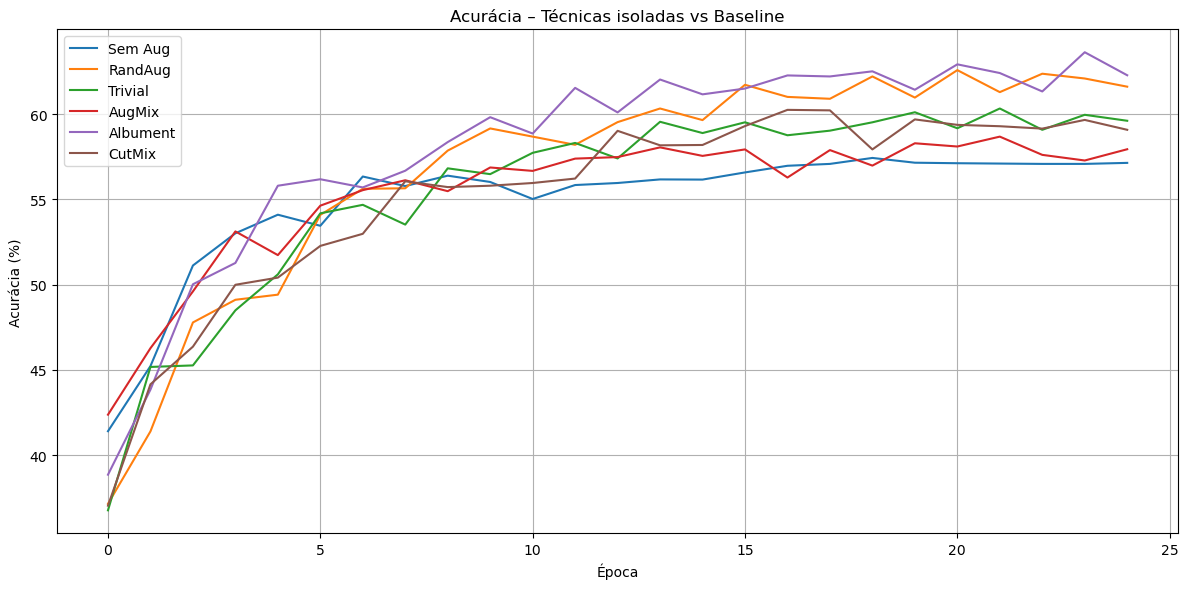

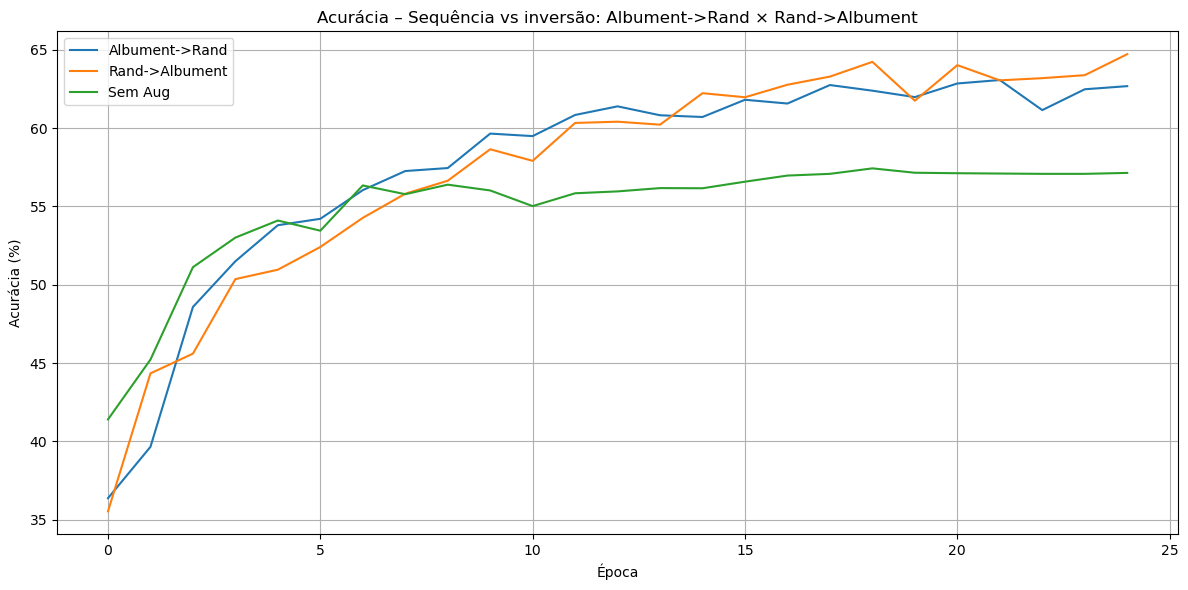

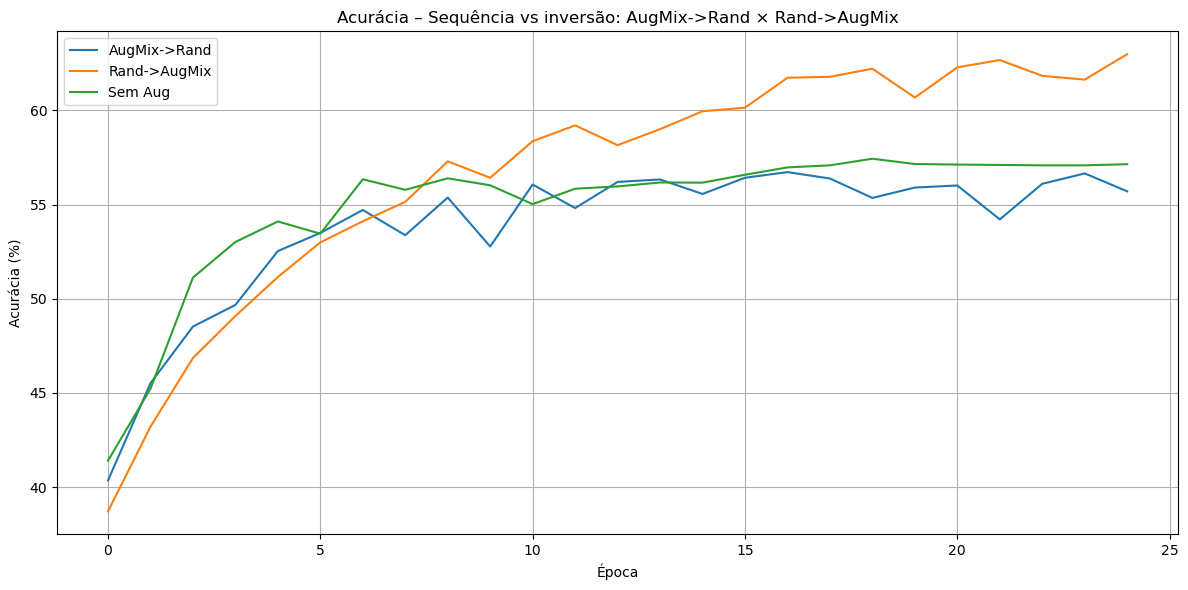

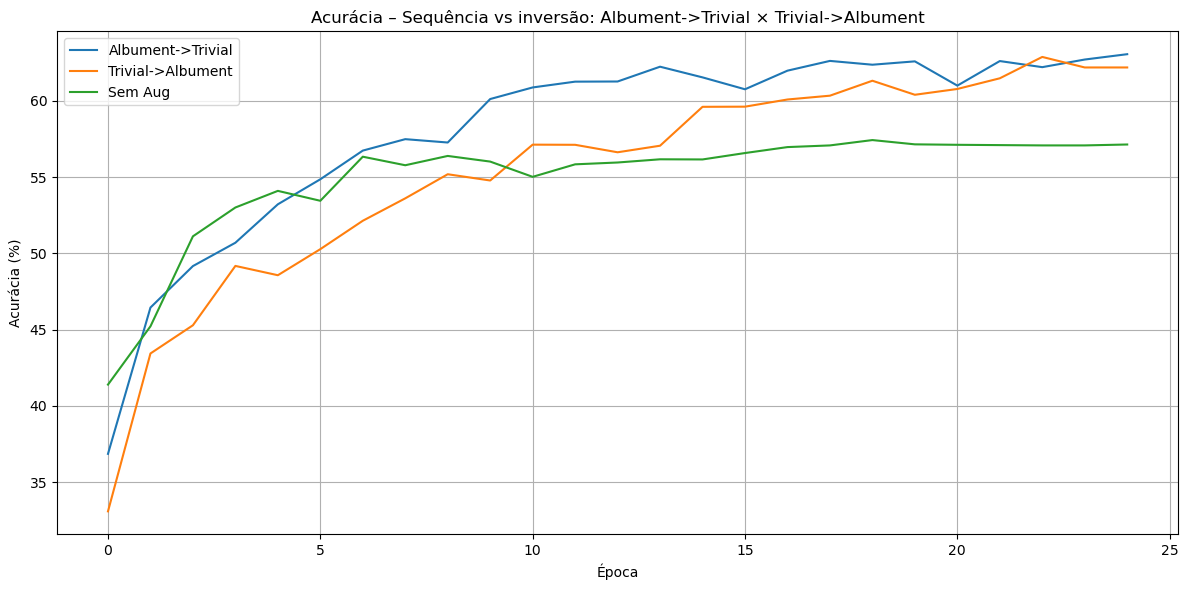

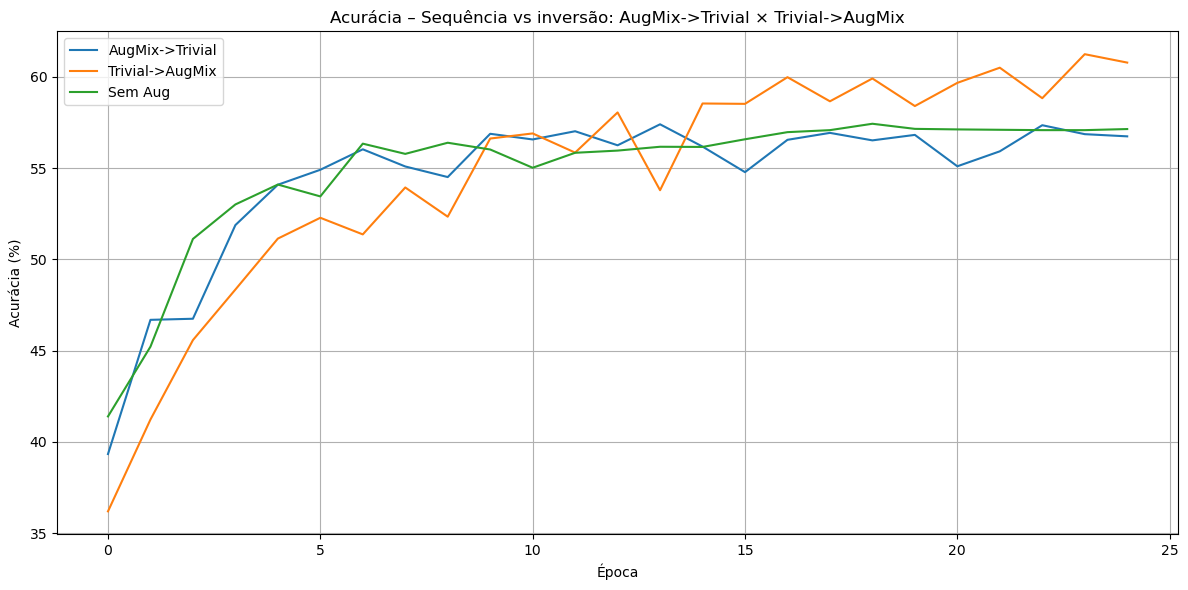

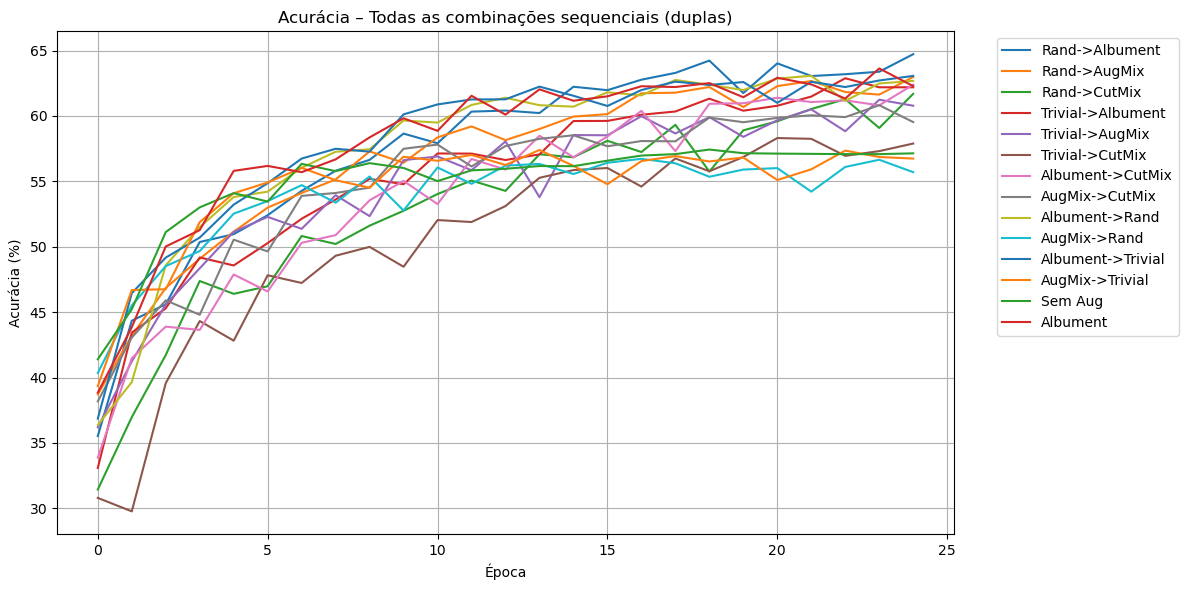

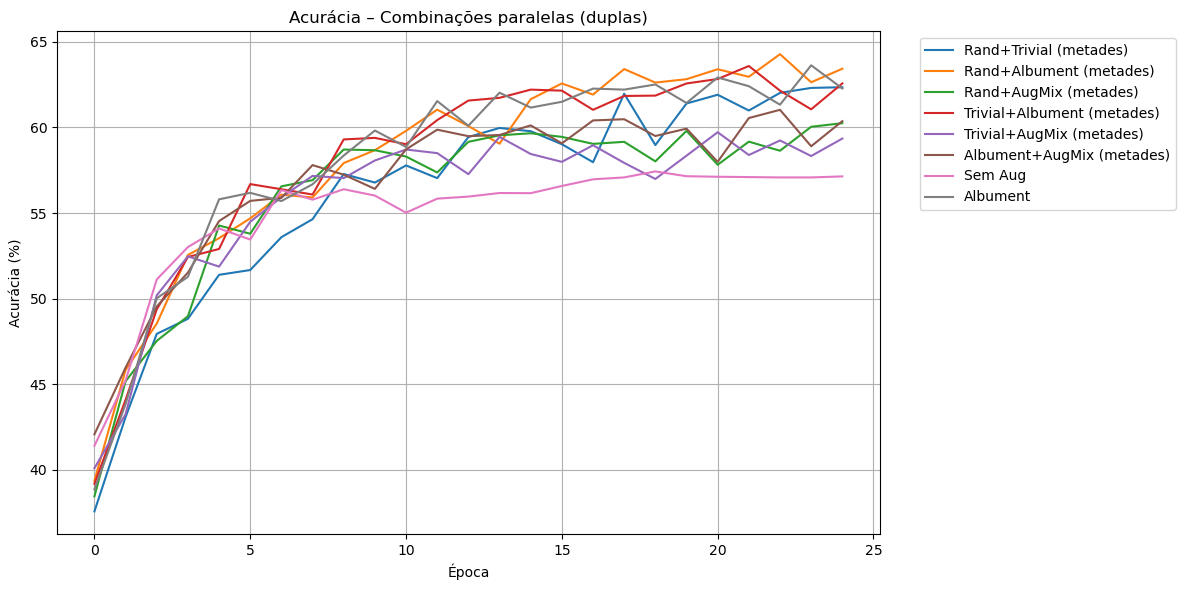

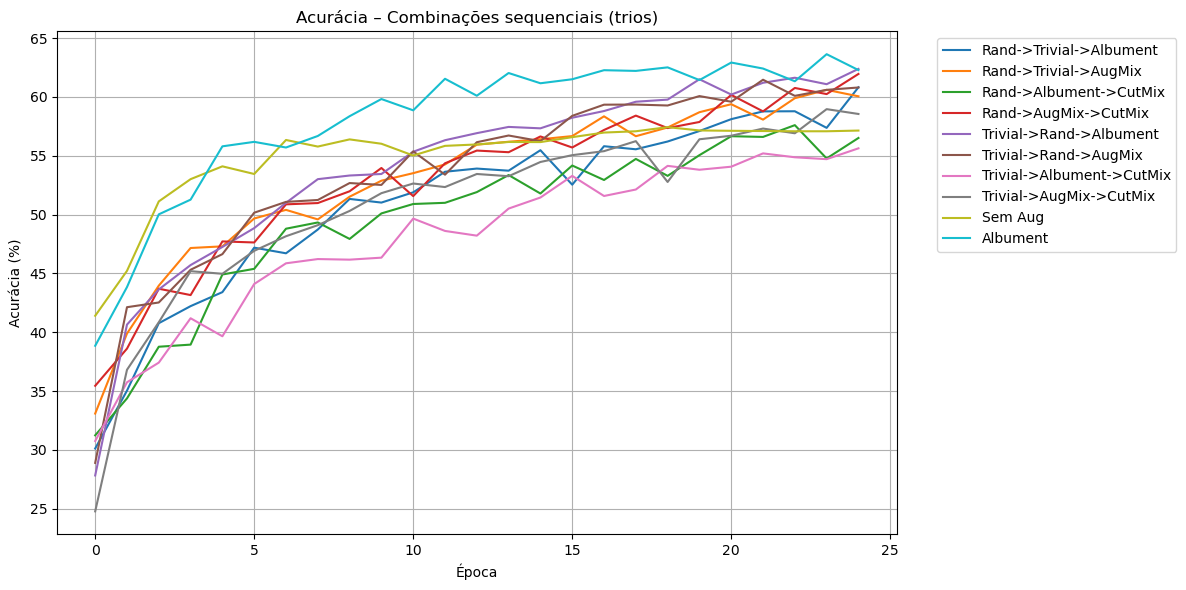

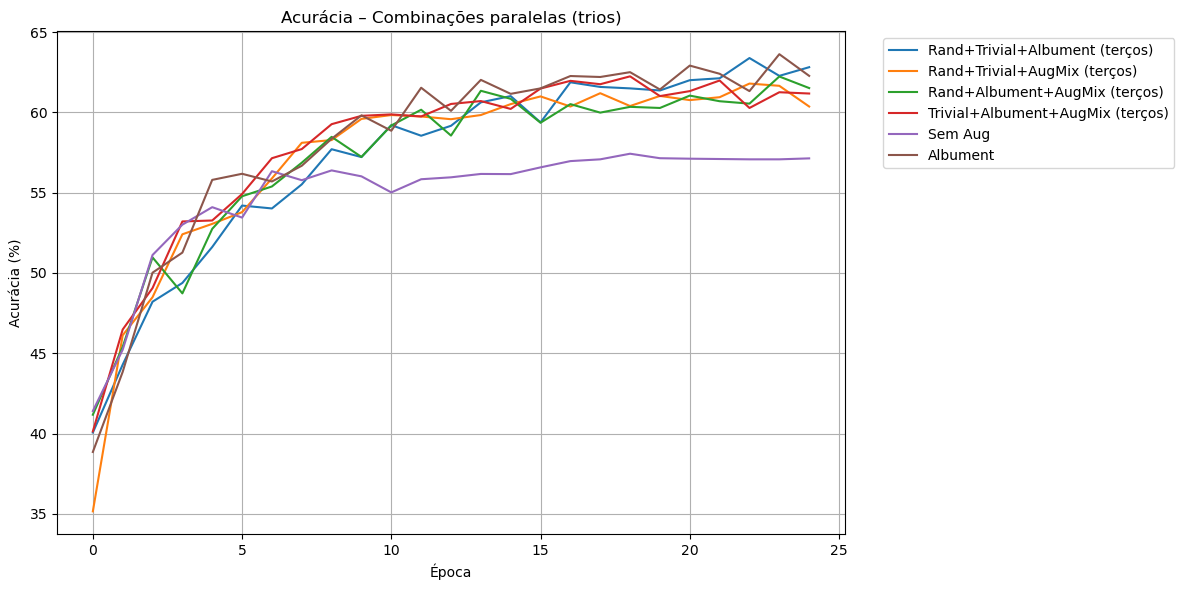

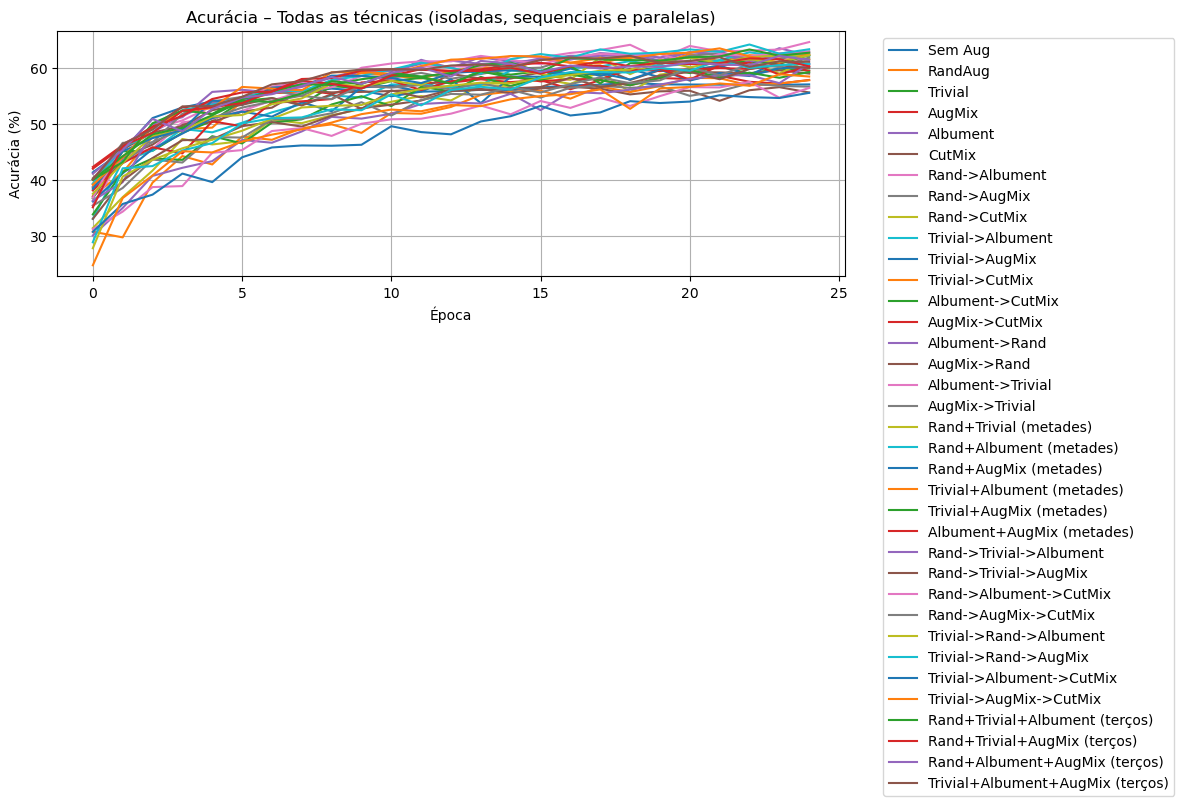

/var/folders/c5/bkgrrfh96ts66yd3z3gdg4640000gn/T/ipykernel_34592/3637671072.py:113: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered = df[df["Tecnica"].str.contains(category_pattern, regex=True)]


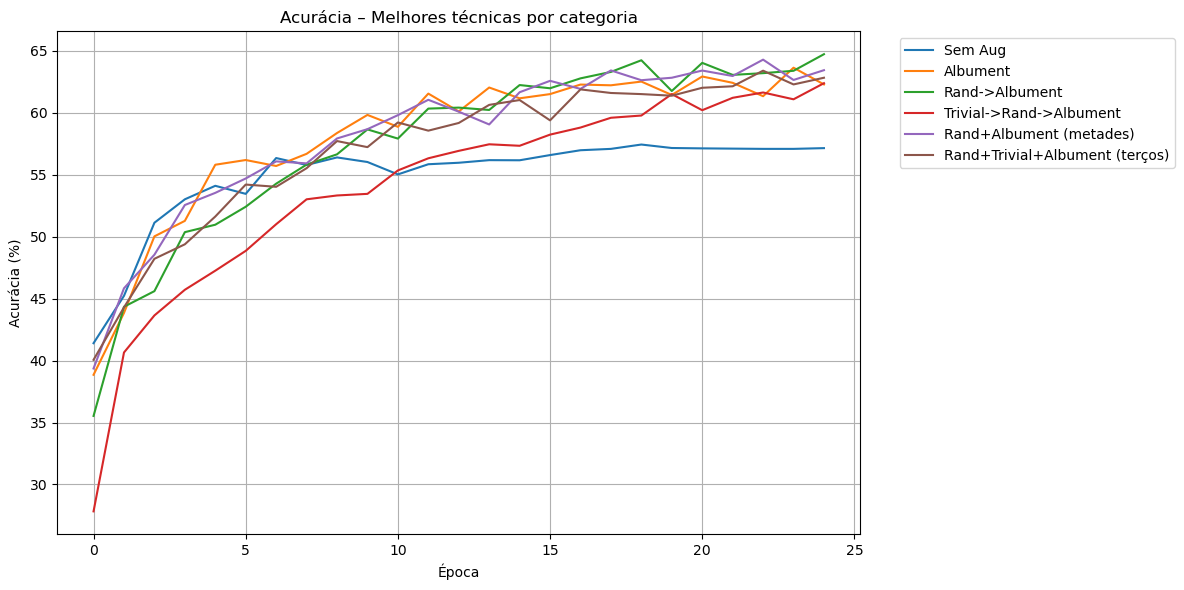

In [12]:
import re
from IPython.display import display

# --------- Monta o DataFrame com métricas consolidadas -------------------
rows = []
for name, h in histories.items():
    rows.append({
        "Tecnica": name,
        "Melhor_acc": max(h["accuracies"]),
        "Media_acc": sum(h["accuracies"]) / len(h["accuracies"]),
        "Desvio": pd.Series(h["accuracies"]).std(),
        "Ep_melhor": h["accuracies"].index(max(h["accuracies"])) + 1,
        "Loss_medio": sum(h["losses"]) / len(h["losses"]),
        "Tempo_total(s)": sum(h["epoch_times"])
    })

df = pd.DataFrame(rows)

# --------- Exporta o resumo para CSV -------------------------------------
csv_path = "summary_all.csv"
df.to_csv(csv_path, index=False)
print(f"CSV salvo em {csv_path} com {len(df)} linhas.")

# --------- dataframe completo por época -----------------------------------
detalhado = []
for name, h in histories.items():
    for epoca, (acc, loss, tempo) in enumerate(zip(h["accuracies"], h["losses"], h["epoch_times"]), 1):
        detalhado.append({
            "Tecnica": name,
            "Epoca": epoca,
            "Acuracia": acc,
            "Loss": loss,
            "Tempo(s)": tempo
        })

df_detalhado = pd.DataFrame(detalhado)
csv_path_detalhado = "metricas_por_epoca_completo.csv"
df_detalhado.to_csv(csv_path_detalhado, index=False)
print(f"CSV salvo em {csv_path_detalhado} com {len(df_detalhado)} linhas.")

# --------- Exibe a tabela no notebook -------------------------------------
display(df.sort_values("Melhor_acc", ascending=False))
display(df_detalhado)

# --------- Função de apoio para gráficos ----------------------------------
def plot_lines(sel, title, legend_out=False):
    plt.figure(figsize=(12,6))
    for name in sel:
        plt.plot(histories[name]["accuracies"], label=name)
    plt.title(title)
    plt.xlabel("Época")
    plt.ylabel("Acurácia (%)")
    plt.grid(True)
    if legend_out:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    else:
        plt.legend()
    plt.tight_layout()
    plt.show()

# --------- 1. Técnicas isoladas vs baseline -------------------------------
pure = ["Sem Aug", "RandAug", "Trivial", "AugMix", "Albument", "CutMix"]
plot_lines([n for n in pure if n in histories],
           "Acurácia – Técnicas isoladas vs Baseline")

# --------- 2. Sequência vs inversão ---------------------------------------
for name in df["Tecnica"]:
    if name.count("->") == 1:
        a, b = name.split("->")
        inv = f"{b}->{a}"
        if inv in histories and a < b:
            plot_lines([name, inv, "Sem Aug"],
                       f"Acurácia – Sequência vs inversão: {name} × {inv}")

# --------- 3. Todas sequências duplas (A → B) -----------------------------
seq2 = [n for n in histories if n.count("->") == 1]
best_iso = (df[~df["Tecnica"].str.contains("->|\+|Sem Aug")]
            .sort_values("Melhor_acc", ascending=False)
            .iloc[0]["Tecnica"])
plot_lines(seq2 + ["Sem Aug", best_iso],
           "Acurácia – Todas as combinações sequenciais (duplas)",
           legend_out=True)

# --------- 4. Paralelas por metades ---------------------------------------
par2 = [n for n in histories if re.search(r"\(metades\)", n)]
plot_lines(par2 + ["Sem Aug", best_iso],
           "Acurácia – Combinações paralelas (duplas)",
           legend_out=True)

# --------- 5. Sequências triplas (A → B → C) ------------------------------
seq3 = [n for n in histories if n.count("->") == 2]
if seq3:
    plot_lines(seq3 + ["Sem Aug", best_iso],
               "Acurácia – Combinações sequenciais (trios)",
               legend_out=True)

# --------- 6. Paralelas por terços ----------------------------------------
par3 = [n for n in histories if re.search(r"\(terços\)", n)]
if par3:
    plot_lines(par3 + ["Sem Aug", best_iso],
               "Acurácia – Combinações paralelas (trios)",
               legend_out=True)

# --------- 7. Todas as técnicas juntas -------------------------------------
plot_lines(list(histories.keys()),
           "Acurácia – Todas as técnicas (isoladas, sequenciais e paralelas)",
           legend_out=True)

# --------- 8. Gráfico com as melhores técnicas de cada categoria -----------

# Helper para filtrar melhor técnica por padrão no nome
def best_in(category_pattern):
    filtered = df[df["Tecnica"].str.contains(category_pattern, regex=True)]
    if not filtered.empty:
        return filtered.sort_values("Melhor_acc", ascending=False).iloc[0]["Tecnica"]
    return None

best_pure    = best_in("^(?!.*(->|\+|Sem Aug)).*$")  # nem sequências, nem paralelas, nem baseline
best_seq2    = best_in("^[^+]*->[^+]*$")             # uma seta → (dupla)
best_seq3    = best_in("^[^+]*->[^+]*->[^+]*$")       # duas setas → (tripla)
best_par2    = best_in(r"\(metades\)")
best_par3    = best_in(r"\(terços\)")

# Coleta os nomes
best_names = ["Sem Aug"] + [n for n in [best_pure, best_seq2, best_seq3, best_par2, best_par3] if n]

# Traça o gráfico
plot_lines(best_names, "Acurácia – Melhores técnicas por categoria", legend_out=True)